In [1]:
import xarray as xr
import s3fs
import matplotlib.pyplot as plt
import pandas as pd
from dask.diagnostics import ProgressBar
import cartopy.crs as ccrs
import numpy as np

import functions as f
%load_ext autoreload
%autoreload 2

s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", client_kwargs=dict(endpoint_url="https://rgw.met.no"))


## DMS Data

In [9]:
s3.ls('escience2022/Antoine/Satellite_Arctic_DMS')

['escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2003_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2004_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2005_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2006_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2007_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2008_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2009_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2010_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2011_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2012_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2013_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2014_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2015_8D_28km.nc',
 'escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2016_8D_28km.nc',
 'esci

## Dask with gateway

In [2]:
from dask.distributed import Client
from dask_gateway import Gateway
gateway = Gateway()

In [3]:
cluster = gateway.new_cluster(worker_memory=2, worker_cores=1)
cluster.scale(8)
client = Client(cluster) # create a dask Gateway cluster
cluster

In [4]:
if cluster:
    client = Client(cluster) # create a dask Gateway cluster
else:
    client = Client()   # create a local dask cluster on the machine.
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /jupyterhub/services/dask-gateway/clusters/daskhub.3ab9517d935644eab53f2f939526b404/status,


In [4]:
# closing open zombies
# clusters=gateway.list_clusters()
# print(clusters )
# for cluster in clusters :
#     cluster= gateway.connect(cluster.name)
#     print(cluster)
#     client = Client(cluster)
#     client.close()
#     cluster.shutdown()

In [17]:
# To close at end of session
client.close()

In [18]:
cluster.shutdown()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:1014: RuntimeWarning: coroutine 'rpc.close_rpc' was never awaited
  self.scheduler_comm.close_rpc()
2022-11-06 17:13:24,175 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


## Open files

In [2]:
#### single file
# file = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A2010_8D_28km.nc'
# file = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_S2004_8D_28km.nc'
# ds = xr.open_dataset(s3.open(file)).squeeze()

### multiple files
s3files = 's3://escience2022/Antoine/Satellite_Arctic_DMS/dms_gsm_A*_8D_28km.nc'
remote_files = s3.glob(s3files)
fileset = [s3.open(file) for file in remote_files]
ds = xr.open_mfdataset(fileset, combine='by_coords')
## remove dependence of lat and long on year
ds['latitude'] = ds.latitude.isel(year=0)
ds['longitude'] = ds.longitude.isel(year=0)
# ds

In [3]:
## add date
import datetime
dates = np.array([
    [datetime.datetime(int(y.values), 1, 1) + datetime.timedelta(d.values - 1) for d in ds.startjulday.sel(year=y)] 
        for y in ds.year])

ds=ds.assign_coords({ "d": (['year','period'],dates ) })
ds=ds.stack(time=['year','period'])
ds=ds.set_index(time='d')
ds

<xarray.Dataset>
Dimensions:      (pixel: 96668, time: 644)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2016-12-26
    year         (time) float64 2.003e+03 2.003e+03 ... 2.016e+03 2.016e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel) float64 dask.array<chunksize=(96668,), meta=np.ndarray>
    latitude     (pixel) float64 dask.array<chunksize=(96668,), meta=np.ndarray>
    startjulday  (time) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    endjulday    (time) float64 dask.array<chunksize=(46,), meta=np.ndarray>
    dms          (pixel, time) float64 dask.array<chunksize=(96668, 46), meta=np.ndarray>

## Selecting area

In [4]:
ds = ds.where(
    (ds.longitude>=-10) & (ds.longitude<=10) & 
    (ds.latitude <=85 ) & (ds.latitude >= 70),
    drop = True)
ds

<xarray.Dataset>
Dimensions:      (pixel: 1033, time: 644)
Coordinates:
  * time         (time) datetime64[ns] 2003-01-01 2003-01-09 ... 2016-12-26
    year         (time) float64 2.003e+03 2.003e+03 ... 2.016e+03 2.016e+03
    period       (time) int64 0 1 2 3 4 5 6 7 8 9 ... 37 38 39 40 41 42 43 44 45
Dimensions without coordinates: pixel
Data variables:
    longitude    (pixel) float64 dask.array<chunksize=(1033,), meta=np.ndarray>
    latitude     (pixel) float64 dask.array<chunksize=(1033,), meta=np.ndarray>
    startjulday  (time, pixel) float64 dask.array<chunksize=(46, 1033), meta=np.ndarray>
    endjulday    (time, pixel) float64 dask.array<chunksize=(46, 1033), meta=np.ndarray>
    dms          (pixel, time) float64 dask.array<chunksize=(1033, 46), meta=np.ndarray>

### plot to check selected area

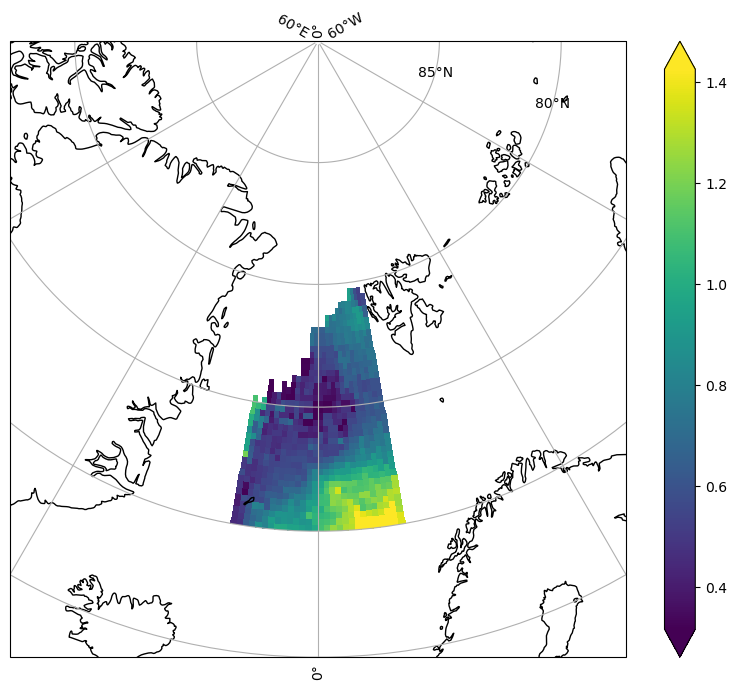

In [7]:
import functions as f

dms_gridded = f.interGali(ds.sel(time='2016-04-22'), 'dms')
fig, ax = plt.subplots(figsize=(8,8),
                       subplot_kw={'projection':ccrs.NorthPolarStereo()})
dms_gridded.plot.pcolormesh( 
        ax = ax,
        cbar_kwargs={ 'orientation':'vertical', 'shrink':.8},
        transform=ccrs.PlateCarree(),
        robust=True
    )
ax.set_extent( [-30,30, 65,90], ccrs.PlateCarree())
ax.gridlines(draw_labels=True)
ax.coastlines()
fig.tight_layout()    

## Average

In [16]:
with ProgressBar():
    avDMS = ds.dms.mean(dim='period').compute()
avDMS

<xarray.DataArray 'dms' (year: 14, pixel: 96668)>
array([[1.6425631 , 1.67667953, 1.62868811, ...,        nan,        nan,
               nan],
       [1.78907402, 1.80125326, 1.79672808, ...,        nan,        nan,
               nan],
       [1.5812639 , 1.6403461 , 1.71797459, ...,        nan,        nan,
               nan],
       ...,
       [1.54723054, 1.52175257, 1.55977582, ...,        nan,        nan,
               nan],
       [1.36886688, 1.40227815, 1.37130959, ...,        nan,        nan,
               nan],
       [1.6528151 , 1.57409634, 1.56683436, ...,        nan,        nan,
               nan]])
Coordinates:
  * year     (year) float64 2.003e+03 2.004e+03 ... 2.015e+03 2.016e+03
Dimensions without coordinates: pixel

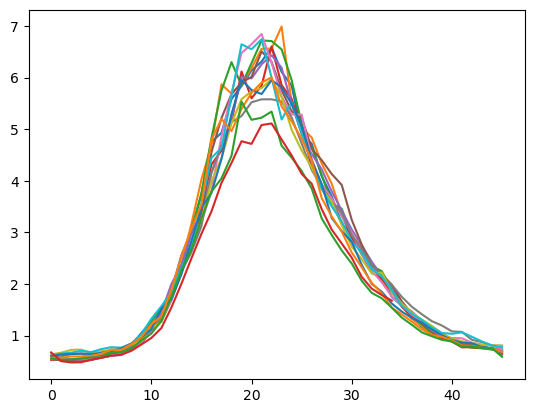

In [14]:
plt.plot(avDMS)